
<div align="center">
  <a href="https://www.w-hs.de/maschinenbau-master-boh/">
    <img src="https://www.w-hs.de/typo3conf/ext/whs/Resources/Public/Images/Pagelayout/w-hs_pagelogo.png" 
    alt="Images" width="500" height="200">
  </a>
</div>
<br>
<h1 align="center"> Sondergebiete der Simulation</h1>
<h3 align="center"> WS 21/22 </h3>
<br />

## Workflow


> * Symbolische Herleitung der Bewegungsgleichung des freien, gedämpften Inversen Pendels mit **`sympy`**.
> * Numerische Lösung der DGL mit Hilfe von **`scipy.itegrate.odeint`**.
> * Trainingspunkte, die eine reale Messung ersetzen, aus numerischer Lösung extrahieren.
> * Interpolation der Punkte mit Hilfe eines *Neuronales Netzes*.
> * Training eines PINNs, indem die DGL-System in die *loss-Funktion eingebettet* wird.


### Environment set up

Sollten Fehlermeldungen erscheinen, obwohl alle benötigten Module installiert sind, hilft es wohlmöglich eine virtuelle Umgebung für das Arbeiten mit PINNs einzurichten:
```bash
conda create -n pinn python=3
conda activate pinn
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
conda install scipy, sympy
```

#### Activate Enviroment
```bash
conda activate pinn
jupyter notebook 
```
<br />

# Credits: [benmoseley](https://github.com/benmoseley/harmonic-oscillator-pinn)

<br />
<br />

In [1]:
import sympy
from sympy import symbols, Function, diff, sin, cos, Matrix, Rational, Eq, solve, lambdify
import sympy.physics.mechanics as mech
mech.init_vprinting()

### Herleitung der Bewegungsgleichungen 

Ausführliche Beschreibung der Herleitung:
[Inverted Pendulum Legrange](https://github.com/lennart2810/InvertedPendulumSDS/blob/master/MKS/Inverted%20Pendulum%20Legrange.ipynb) 

In [2]:
# symbolischen Variablen anlegen
t, l, M, m, g, D, d, F = symbols('t l M m g, D, d, F')

# Zwangsbedingung
y = 0

# generalisierte Koordinaten und deren Ableitungen:
x = Function('x')(t)
x_d = diff(x,t)
x_dd = diff(x_d,t)

theta = Function('theta')(t)
theta_d = diff(theta,t)
theta_dd = diff(theta,t,t)

# Kinematik
x2, y2 = x - l * sin(theta), y + l * cos(theta)
x2_d, y2_d = x2.diff(t), y2.diff(t)

# Legrange-Funktion
T = Rational(1,2) * M * (x_d)**2 + Rational(1,2) * m * (x2_d**2 + y2_d**2)
V = M * g * y + m * g * y2 
L = T - V

# Euler-Legrange
LE_x = diff(diff(L, x_d), t) - diff(L, x)
LE_x = Eq(LE_x, F -  x_d * D)
LE_theta = diff(diff(L, theta_d), t) - diff(L, theta)
LE_theta = Eq(LE_theta, -theta_d * d)
display(Matrix([[LE_x.simplify()], [LE_theta.simplify()]]))

# Nach x_dd und theta_dd umstellen
solutions = solve([LE_x, LE_theta], (x_dd, theta_dd), simplify=True)

C:\Users\lenna\anaconda3\envs\pinn\lib\site-packages\sympy\matrices\repmatrix.py:98: SymPyDeprecationWarning: 

non-Expr objects in a Matrix has been deprecated since SymPy 1.9. Use
list of lists, TableForm or some other data structure instead. See
https://github.com/sympy/sympy/issues/21497 for more info.

  SymPyDeprecationWarning(


⎡                   ⎛          2                 ⎞⎤
⎢D⋅ẋ - F = -M⋅ẍ - m⋅⎝l⋅sin(θ)⋅θ̇  - l⋅cos(θ)⋅θ̈ + ẍ⎠⎥
⎢                                                 ⎥
⎣     d⋅θ̇ = -l⋅m⋅(-g⋅sin(θ) + l⋅θ̈ - cos(θ)⋅ẍ)     ⎦

### Umwandlung des symbolischen Gleichungssystems in numerische Funktionen mit `sympy.lambdify`.

In [3]:
dxdt = lambdify(x_d, x_d)
dvdt = lambdify((t,g,M,m,l,x_d,theta,theta_d,F,D,d), solutions[x_dd])

dthetadt = lambdify(theta_d, theta_d)
domegadt = lambdify((t,g,M,m,l,x_d,theta,theta_d,F,D,d), solutions[theta_dd])

def dSdt(S, t, M, m, D, d, l, F):
    _x, _v, _theta, _omega = S
    return [
        dxdt(_v),
        dvdt(t, g, M, m, l, _v, _theta, _omega, F, D, d),
        dthetadt(_omega),
        domegadt(t, g, M, m , l, _v, _theta, _omega, F, D, d)
    ]

### Daten generieren

Trainingspunkte x: (57,)


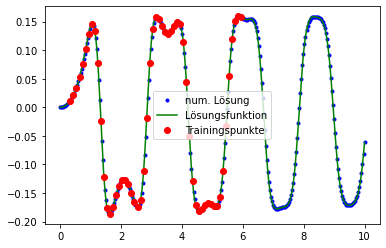

Trainingspunkte theta: (57,)


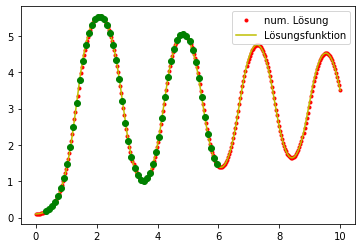

Zeitpunkte der Trainingsdaten: (57,) <class 'numpy.ndarray'>
Trainingspunkte: (57, 2)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interpolate

t1 = 10                          # s 
samples = 300                    # n 
t = np.linspace(0, t1, samples)  # s

# numerische Größen
g = 9.81                         # m/s^2
M = 5                            # kg
m = 1                            # kg
l = 1                            # m
F = 0                            # N
D = 0.5                          # N*s/m
d = 0.1                          # Nm*s

S0 = [0, 0, 0.1, 0]              # m, m/s, rad, rad/s

# numerische Lösung
ans = odeint(dSdt, y0=S0, t=t, args=(M, m, D, d, l, F))
x = ans.T[0]
theta = ans.T[2]

# numerische Lösung --> Lösungsfunktion interpolieren (für DeepXDE)
t_new = np.linspace(0, t1, samples+2000)    
x_f = interpolate.interp1d(t, x, 'cubic')
theta_f = interpolate.interp1d(t, theta, 'cubic')

# 'Messwerte'
a, b, i = 10, 180, 3 # jeden i. Punkt im Intervall [a,b] 
t_data = t[a:b:i]
x_data = x[a:b:i]
theta_data = theta[a:b:i]

# Data für NN zusammenfassen
data = np.concatenate((x_data, theta_data)).reshape(2, len(t_data)).T

# Visualisierung
print('Trainingspunkte x:', x_data.shape)
plt.plot(t, x, 'b.', label='num. Lösung')
plt.plot(t_new, x_f(t_new), 'g-', label='Lösungsfunktion')
plt.plot(t_data, data[:,0], 'ro', label='Trainingspunkte') 
plt.legend(loc='best')
plt.show()

print('Trainingspunkte theta:', theta_data.shape)
plt.plot(t, theta, 'r.', label='num. Lösung')
plt.plot(t_new, theta_f(t_new), 'y-', label='Lösungsfunktion')
plt.plot(t_data, data[:,1], 'go')
plt.legend(loc='best')
plt.show()

print('Zeitpunkte der Trainingsdaten:', t_data.shape, type(t_data))
print('Trainingspunkte:', data.shape)

### Daten in torch Tensoren umwandeln

In [5]:
import torch

t = torch.Tensor(t).view(-1,1)
t_data = torch.Tensor(t_data).view(-1,1)
x_data = torch.Tensor(x_data).view(-1,1)
theta_data = torch.Tensor(theta_data).view(-1,1)
data = torch.Tensor(data).view(-1,2)

print('t:', t.shape)
print('t_data:', t_data.shape)
print('x_data:', x_data.shape)
print('theta_data:', theta_data.shape)
print('data:', data.shape)

t: torch.Size([300, 1])
t_data: torch.Size([57, 1])
x_data: torch.Size([57, 1])
theta_data: torch.Size([57, 1])
data: torch.Size([57, 2])


### Hilfsfunktionen, um Lernprozess zu Visualisieren

In [6]:
from PIL import Image

def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

    
def plot_my_result(t, x, theta, t_data, data, pred, ps=None):
    
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)
    fig.suptitle(name_plot, fontsize=10)
    
    # wahren Werte
    plt.plot(t, x, 'k--', linewidth=2, alpha=0.8, label="numerical solution $x$")
    plt.plot(t, theta, 'b--', linewidth=2, alpha=0.8, label=r"numerical solution $\theta$")
    
    # Messwerte
    plt.scatter(t_data, data[:,0], s=30, color="grey", label='Training data $x$')
    plt.scatter(t_data, data[:,1], s=30, color="royalblue", label=r'Training data $\theta$')
    
    # Zeitpunkte der Physik Loss berechnung:
    if ps is not None:
        plt.scatter(ps, -3*torch.ones_like(ps), s=20, color="limegreen", alpha=0.4, label='physics trainings')
    
    # Prediction
    plt.plot(t, pred[:,0], color="black", linewidth=2, alpha=0.8, label="Prediction $x$")
    plt.plot(t, pred[:,1], color="blue", linewidth=2, alpha=0.8, label=r"Prediction $\theta$")
    
    # Anpassungen für die Darstellung des Plots
    plt.text(torch.max(t)*1.01,torch.max(data),"episode: %i"%(i),fontsize=16,color="k")
    
    x_max = torch.max(t)
    y_min = torch.min(pred[:,1])
    y_max = torch.max(pred[:,1])
    
    plt.xlim(0, t1)
    plt.ylim(-1, 6.3)
    
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.axis("off")

### Klasse eines Neuronalen Netzes

> Die Methode `forward` nimmt den Input entgegen, führt diesen durch das Netz und produziert somit die *prediction* des Modells.

In [7]:
import torch.nn as nn

class Network(nn.Module):
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Neuronal Network (NN)

> Als Erstes wird die erstellte `Network` Klasse genutzt, um ein **normales** *fully connected Network* darauf zu trainieren, die Zeitverläufe der Bewegungsleichungen von $x$ und $\theta$ anzunähern.

<div align="center">
  <a href="https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/">
    <img src="https://benmoseley.blog/wp-content/uploads/2021/08/nn.png" 
    alt="Images" width="420">
  </a>
</div>

> **Die Bezeichnungen der Input-Daten $X$ und der Netz-Gewichte $\theta_i$ in der gegebenen Abbildung ist für das System des inversen Pendels sehr ungünstig, da die Wagenposition ($x$) und der Auslenkwinkel ($\theta$) mit den selben Variablen bezeichnet werden.**

> Die Trainingsdaten (in Form der Koordinaten $x$ und $\theta$ in Abhängigkeit der Zeit $t$) werden als Input $X$ an das Netz übergeben.

> Das Netz versucht die Lösungen der Bewegungsgleichungen als Output $U$ vorherzusagen.

> Die Abweichungen zwischen Input und Output werden als *loss* bezeichnet und über die *Backpropagation* in das Netz zurückgeführt, um den mittleren quadratischen Fehler (*mean-squared-error*) zu minimieren.

[benmoseley](https://github.com/benmoseley/harmonic-oscillator-pinn)

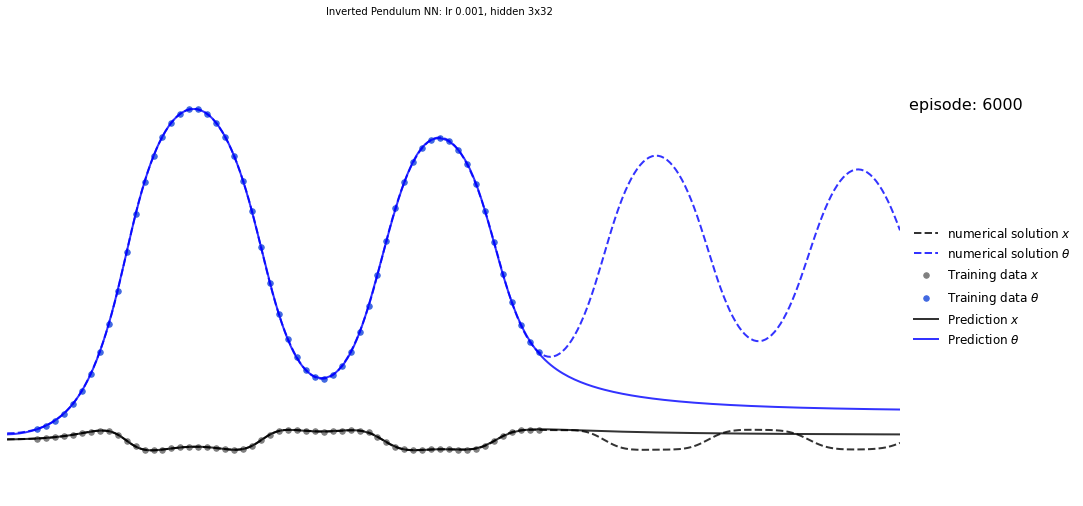

In [8]:
torch.manual_seed(123) # Startgewichte sind vom Seed abhängig

lr_data = 1e-3
num_layers = 3 # Anzahl der hidden-layers
num_hidden = 32 # Anzal der Knoten je hidden-layer
 
model = Network(1,2,num_hidden,num_layers) # ein Input, zwei Outputs (x_prediction, theta_prediction)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_data)

episodes = 6000 # Anzahl der Trainingsepisoden
num_save_plot = round(episodes/60) # übernimmt 60 Bilder ins gif

files = []
name_plot = 'Inverted Pendulum NN: lr %s, hidden %sx%s'%(lr_data, num_layers, num_hidden)
name_gif = 'NN_lr_%s_hidden_%sx%s_episodes_%s.gif'%(lr_data, num_layers, num_hidden, episodes)

for i in range(1, episodes+1):

    optimizer.zero_grad()

    pred = model(t_data) # Prediction

    loss = torch.mean((pred - data)**2) # mittlerer, quadratischer Fehler

    loss.backward() # Backpropagation
    optimizer.step() 

    if (i) % num_save_plot == 0: 

        pred = model(t).detach()

        plot_my_result(t, x, theta, t_data, data, pred)

        file = "plots/nn_%.8i.png"%(i)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i) % episodes == 0: plt.show()
        else: plt.close("all")

save_gif_PIL(name_gif, files, fps=5, loop=0)       

> ##### Das NN kann den physikalischen Prozess in der Nähe der Trainingsdaten genau annähern, aber keineswegs verallgemeinern bzw. den weitern Zeitverlauf vorhersagen. 

## Physics Informed Neural Network


> **PINN** $\rightarrow$ Die bekannte Differentialgleichungen wird während des Trainings in die Verlustfunktion eingebunden.

<div align="center">
  <a href="https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/">
    <img src="https://benmoseley.blog/wp-content/uploads/2021/08/pinn.png" 
    alt="Images" width="600">
  </a>
</div>

> An definierten Zeitpunkten (`t_physics`) wird der Output des Netzes ($x_{prediction}$ und $\theta_{prediction}$) mit `torch.autograd.grad()` nach der Zeit abgeleitet.

> Die Gradienten werden genutzt, um das Gleichungssystem zu Lösen.
 
> Abweichungen von der exakten Lösungen gehen als **zusätzlicher Term** in die Verlustfunktion ein.

> Der *physikalische Verlust* zielt darauf ab, sicherzustellen, dass die erlernte Lösung mit der zugrunde liegenden DGL übereinstimmt. 




[benmoseley](https://github.com/benmoseley/harmonic-oscillator-pinn)

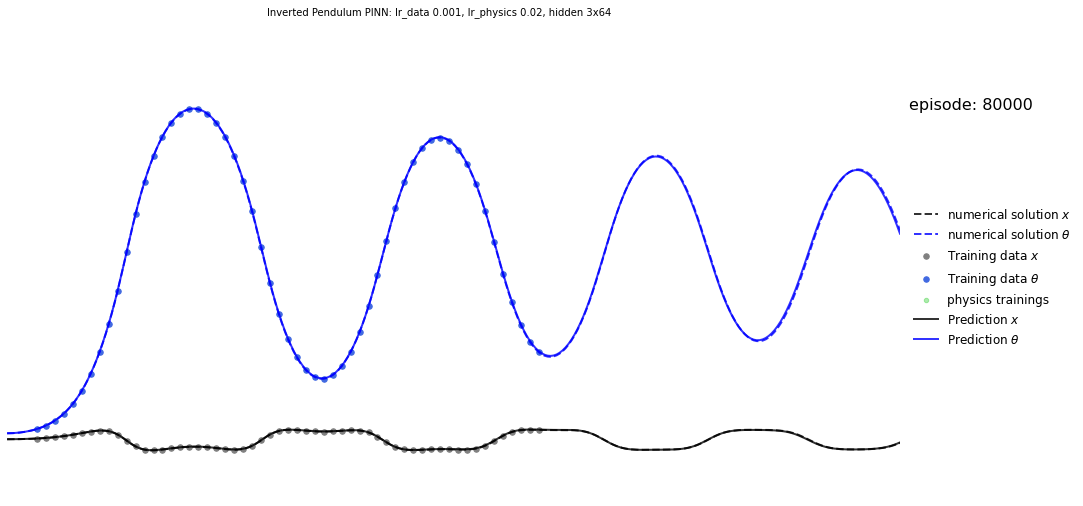

duration: 398 [s]


In [9]:
import time
from torch import sin, cos

# Zeitpunkte, an denen Lösung der DGL berechnet wird 
t_physics = torch.linspace(0,t1,t1*5).view(-1,1).requires_grad_(True)

torch.manual_seed(123)

# Netzparameter
lr_data = 1e-3
lr_physics = 2e-2
num_layers = 3
num_hidden = 64

model = Network(1,2,num_hidden,num_layers)
optimizer = torch.optim.Adam(model.parameters(),lr=lr_data)

episodes = 80000
num_plots = 500                        

files = []
name_plot = 'Inverted Pendulum PINN: lr_data %s, lr_physics %s, hidden %sx%s'%(lr_data, lr_physics,num_layers, num_hidden)
name_gif = 'PINN_lr_data_%s_lr_physics_%s_hidden_%sx%s_episodes_%s.gif'%(lr_data, lr_physics,num_layers, num_hidden, episodes)


start = time.time()
for i in range(1, episodes+1):

    optimizer.zero_grad()

    # Loss durch die Trainingsdaten
    pred = model(t_data)
    loss_data = torch.mean((pred - data)**2) 

    # Prediction an den Sample-Punkten t_physics
    pred = model(t_physics)
    
    # x_prediction
    x_p = pred[:,0].view(-1,1)
    x_d_p = torch.autograd.grad(x_p, t_physics, torch.ones_like(x_p), create_graph=True)[0]
    x_dd_p = torch.autograd.grad(x_d_p, t_physics, torch.ones_like(x_d_p), create_graph=True)[0]
    
    # theata_prediction
    theta_p = pred[:,1].view(-1,1)
    theta_d_p = torch.autograd.grad(theta_p, t_physics, torch.ones_like(theta_p), create_graph=True)[0]
    theta_dd_p = torch.autograd.grad(theta_d_p, t_physics, torch.ones_like(theta_d_p), create_graph=True)[0]
    
    sin_theta_p = sin(theta_p)
    cos_theta_p = cos(theta_p)
    
    # Gradienten in DGL einsetzen
    physics_x = D*x_d_p + M*x_dd_p + m*(l*sin_theta_p*theta_d_p**2 - l*cos_theta_p*theta_dd_p + x_dd_p) - F
    physics_theta = d*theta_d_p + l*m*(-g*sin_theta_p + l*theta_dd_p - cos_theta_p*x_dd_p)
    
    # Physics Loss berechnen
    loss_physics = lr_physics * torch.mean(physics_x**2) + lr_physics * torch.mean(physics_theta**2)
    
    # Gesamtfehler ins Netzt backpropagieren
    loss = loss_data + loss_physics
    loss.backward() 
    optimizer.step() 
    
    # Training Visualisieren
    if (i % (episodes/num_plots)) == 0:   
        
        pred = model(t).detach()
        ps = t_physics.detach()
        
        plot_my_result(t, x, theta, t_data, data, pred, ps)
        
        file = "plots/pinn_%.8i.png"%(i)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        # show 5 plots
        if (i % (episodes)) == 0: plt.show()
        else: plt.close("all")
            

print('duration: %s [s]' % round(time.time() - start))            
save_gif_PIL(name_gif, files, fps=15, loop=0)  

> ##### Das *physikalisch informierte neuronale Netzwerk* ist in der Lage, die Lösung weit weg von den experimentellen Datenpunkten zu bestimmen. 

> ##### Man könnte argumentieren, dass es tatsächlich eine Vorstellung von der Physik des Inversen Pendels hat.

# DeepXDE

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term

Compiling model...
Building feed-forward neural network...
'build' took 0.035812 s



C:\Users\lenna\anaconda3\envs\pinn\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+22=22. 
  warnings.warn("The balance properties of Sobol' points require "
C:\Users\lenna\anaconda3\envs\pinn\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
C:\Users\lenna\anaconda3\envs\pinn\lib\site-packages\keras\legacy_tf_layers\core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 0.920871 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.63e-06, 1.76e+00, 1.74e-01, 4.90e-02]    [1.49e-06, 1.75e+00, 1.74e-01, 4.90e-02]    [1.04e+00]    
1000      [1.83e-06, 5.21e-04, 9.94e-12, 8.75e-03]    [1.61e-06, 4.38e-04, 9.94e-12, 8.75e-03]    [1.00e+00]    
2000      [1.94e-06, 8.70e-04, 6.70e-12, 7.83e-03]    [1.70e-06, 5.62e-04, 6.70e-12, 7.83e-03]    [1.00e+00]    
3000      [2.81e-05, 1.14e-03, 2.53e-10, 6.76e-03]    [2.96e-05, 3.70e-04, 2.53e-10, 6.76e-03]    [1.00e+00]    
4000      [3.79e-05, 9.73e-04, 4.50e-11, 5.69e-03]    [2.07e-05, 1.17e-04, 4.50e-11, 5.69e-03]    [1.00e+00]    
5000      [1.87e-05, 1.97e-02, 1.97e-08, 5.05e-03]    [5.26e-06, 2.13e-02, 1.97e-08, 5.05e-03]    [1.00e+00]    
6000      [8.12e-06, 1.02e-04, 3.12e-15, 6.87e-04]    [1.01e-05, 1.96e-03, 3.12e-15, 6.87e-04]    [1.00e+00]    
7000      [5.54e-06, 1.3

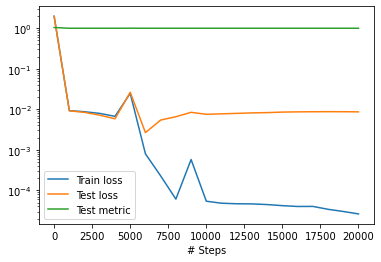

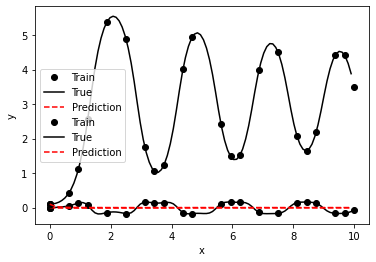

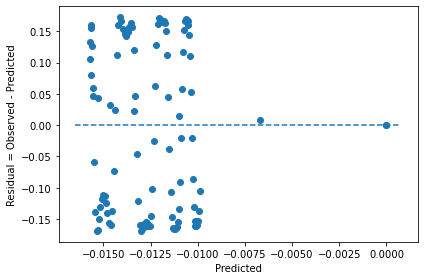

In [10]:
import deepxde as dde
import numpy as np
from tensorflow import sin, cos


def ode_system_ip(t, y):
    
    x, theta = y[:, 0:1], y[:, 1:]
    
    x_d = dde.grad.jacobian(y, t, i=0)
    theta_d = dde.grad.jacobian(y, t, i=0)
    
    x_dd = dde.grad.hessian(y, t, component=0, i=0, j=0)
    theta_dd = dde.grad.hessian(y, t, component=1, i=0, j=0)
    
    sin_theta = sin(theta)
    cos_theta = cos(theta)
        
    eq_x = D*x_d + M*x_dd + m*(l*sin_theta*theta_d**2 - l*cos_theta*theta_dd + x_dd) - F
    eq_theta = d*theta_d + l*m*(-g*sin_theta + l*theta_dd - cos_theta*x_dd)

    return [eq_x, eq_theta]


def boundary(_, on_initial):
    return on_initial

def func(t):
    return np.hstack((x_f(t), theta_f(t)))


geom = dde.geometry.TimeDomain(0, t1)
ic1 = dde.IC(geom, x_f, boundary, component=0)
ic2 = dde.IC(geom, theta_f, boundary, component=1)
data = dde.data.PDE(geom, ode_system_ip, [ic1, ic2], num_domain=20, num_boundary=2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [2]
activation = "sigmoid"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)